<a href="https://colab.research.google.com/github/nickymind/DOE-Econometria/blob/main/Nowcasting_PIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels --upgrade
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 45.1 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd

# 1. Carga y ajuste de Series


In [3]:
pd.set_option('display.float_format',  '{:,}'.format)

In [33]:
trx=pd.read_csv('https://raw.githubusercontent.com/nickymind/DOE-Econometria/main/Data%20trx%20v2.csv', sep=';', encoding='latin-1')

In [5]:
trx.head()

,Periodo,Año,Fecha,N_Mes,S_ATM,Q_ATM,S_CAJA,Q_CAJA,S_TC,Q_TC,S_TD,Q_TD,S_Transf,Q_Transf
0,202109,2021,1/9/21 00:00,9,"2,470,454,581.65","364,868.0","1,343,225,437.97","11,584.0","108,162,943.57",25117,"970,780,164.47","383,681.0","2,566,476,688.9","192,309.0"
1,202109,2021,2/9/21 00:00,9,"2,548,740,104.56","369,785.0","1,412,150,557.47","11,110.0","85,539,020.98",20831,"977,337,373.0","389,395.0","2,570,610,668.03","192,484.0"
2,202109,2021,3/9/21 00:00,9,"2,790,571,218.86","390,939.0","1,912,946,253.56","14,220.0","91,824,075.48",23344,"1,099,383,834.02","433,393.0","2,816,008,441.9","212,779.0"
3,202109,2021,4/9/21 00:00,9,NaN,NaN,NaN,NaN,"79,277,854.42",19693,"1,120,945,104.32","439,813.0",NaN,NaN
4,202109,2021,5/9/21 00:00,9,NaN,NaN,NaN,NaN,"40,059,232.11",11549,"540,123,107.94","253,641.0",NaN,NaN


In [ ]:
#trx['Fecha'] = pd.to_datetime(trx.Fecha).dt.to_period('m')

In [34]:
emae=pd.read_csv('https://raw.githubusercontent.com/nickymind/DOE-Econometria/main/EMAE.csv', sep=',', encoding='latin-1', header=0) # original
emae1=pd.read_csv('https://raw.githubusercontent.com/nickymind/DOE-Econometria/main/EMAE1.csv', sep=',', encoding='latin-1', header=0) # desestacionalizada
emae2=pd.read_csv('https://raw.githubusercontent.com/nickymind/DOE-Econometria/main/EMAE2.csv', sep=',', encoding='latin-1', header=0) # tendencia ciclo


In [10]:
trx.drop(trx.index[trx['Periodo'] == 202211], inplace=True)

In [11]:
trx.drop(trx.index[trx['Periodo'] == 202212], inplace=True)

In [12]:
trx.drop(trx.index[trx['Periodo'] == 202301], inplace=True)

In [37]:
emae.drop(emae.index[emae['Periodo'] == 202108], inplace=True)
emae1.drop(emae.index[emae1['Periodo'] == 202108], inplace=True)
emae2.drop(emae.index[emae2['Periodo'] == 202108], inplace=True)

In [14]:
trx_agrupmes=trx.groupby(['Periodo']).sum()

In [20]:
trx_agrupmes.head(15)

,Periodo,Año,N_Mes,S_ATM,Q_ATM,S_CAJA,Q_CAJA,S_TC,Q_TC,S_TD,Q_TD,S_Transf,Q_Transf
0,202109,60630,270,"58,789,743,679.19","8,916,269.0","33,535,452,807.72","280,631.0","13,916,704,537.6",3362919,"24,503,367,623.97","10,565,832.0","54,505,185,542.46","4,425,462.0"
1,202110,62651,310,"59,397,794,926.83","8,758,404.0","34,518,749,819.22","278,723.0","28,145,229,157.34",6147408,"28,134,615,010.62","11,950,886.0","54,245,880,146.11","3,747,904.0"
2,202111,60630,330,"68,553,238,783.200005","9,508,422.0","37,915,961,677.52","292,272.0","29,638,326,822.18",5640658,"28,124,349,814.32","11,593,239.0","57,215,729,678.06","3,922,719.0"
3,202112,62651,372,"88,879,461,348.04","10,931,282.0","51,635,687,934.84","376,705.0","30,148,240,607.22",5745105,"39,295,148,363.03","14,589,180.0","68,186,780,263.59","4,460,891.0"
4,202201,62682,31,"69,931,623,292.08","8,676,702.0","31,704,018,266.0","249,572.0","26,206,466,771.23",5037420,"32,017,977,035.78","12,190,170.0","60,336,773,062.16","3,812,772.0"
5,202202,56616,56,"63,925,226,645.85","7,643,904.0","33,179,919,161.02","266,839.0","24,353,094,138.98",4413592,"31,680,915,645.74","11,530,487.0","55,473,063,148.36","3,468,735.0"
6,202203,62682,93,"80,253,122,621.05","9,243,845.0","41,787,003,852.87","305,099.0","33,942,750,566.6",6053923,"33,968,533,449.5","12,214,045.0","71,907,030,192.15","4,427,171.0"
7,202204,60660,120,"74,991,115,864.51","8,478,312.0","39,868,408,768.03","285,384.0","31,845,435,352.63",5382990,"35,592,822,221.2","12,241,702.0","69,621,308,979.92","4,185,579.0"
8,202205,62682,155,"86,706,432,015.26","9,400,206.0","46,467,498,757.19","316,203.0","36,763,114,676.55",5790095,"37,346,813,087.87","12,377,354.0","79,415,301,911.6","4,577,626.0"
9,202206,60660,180,"101,521,146,886.45","10,065,223.0","55,635,719,288.909996","355,561.0","41,149,805,463.67",5509061,"44,615,940,340.39","13,680,771.0","90,265,914,624.94","4,949,990.0"


In [38]:
emae.head(15)

,Periodo,Indice
1,202109,140.845981271007
2,202110,140.562729892158
3,202111,145.463587294665
4,202112,146.03073105734
5,202201,136.169863072769
6,202202,137.617239121186
7,202203,153.92877566655
8,202204,153.733594055258
9,202205,162.678500482183
10,202206,159.899438889734


In [39]:
trx_agrupmes.reset_index(inplace=True)
emae.reset_index(inplace=True)

In [26]:
trx_agrupmes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     14 non-null     int64  
 1   Periodo   14 non-null     int64  
 2   Año       14 non-null     int64  
 3   N_Mes     14 non-null     int64  
 4   S_ATM     14 non-null     float64
 5   Q_ATM     14 non-null     float64
 6   S_CAJA    14 non-null     float64
 7   Q_CAJA    14 non-null     float64
 8   S_TC      14 non-null     float64
 9   Q_TC      14 non-null     int64  
 10  S_TD      14 non-null     float64
 11  Q_TD      14 non-null     float64
 12  S_Transf  14 non-null     float64
 13  Q_Transf  14 non-null     float64
dtypes: float64(9), int64(5)
memory usage: 1.7 KB


In [27]:
emae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    14 non-null     int64  
 1   Periodo  14 non-null     int64  
 2   Indice   14 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 464.0 bytes


In [28]:
assert set(emae.Periodo) == set(trx_agrupmes.Periodo), "periods in the datasets do not match"

In [43]:
trx_emae = pd.merge(trx_agrupmes, emae, on='Periodo', how='left')

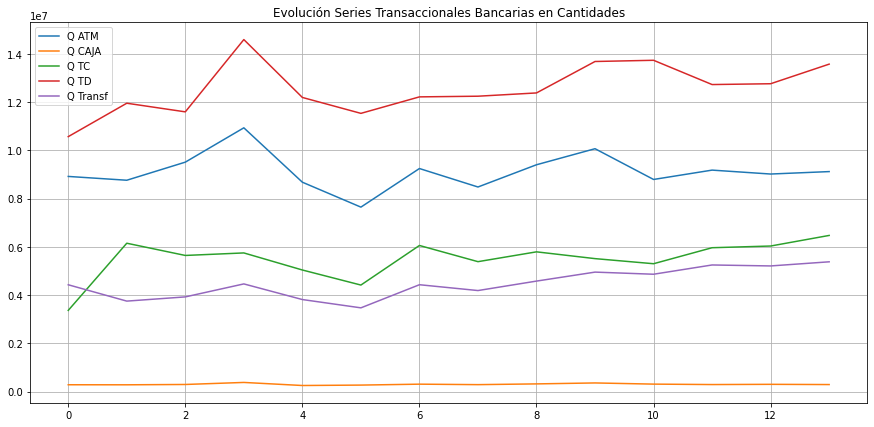

In [44]:
plt.figure(figsize=(15, 7))
plt.plot(trx_agrupmes.Q_ATM, label='Q ATM')
plt.plot(trx_agrupmes.Q_CAJA, label='Q CAJA')
plt.plot(trx_agrupmes.Q_TC, label='Q TC')
plt.plot(trx_agrupmes.Q_TD, label='Q TD')
plt.plot(trx_agrupmes.Q_Transf, label='Q Transf')
plt.title('Evolución Series Transaccionales Bancarias en Cantidades')
plt.grid(True)
plt.legend()
plt.show()

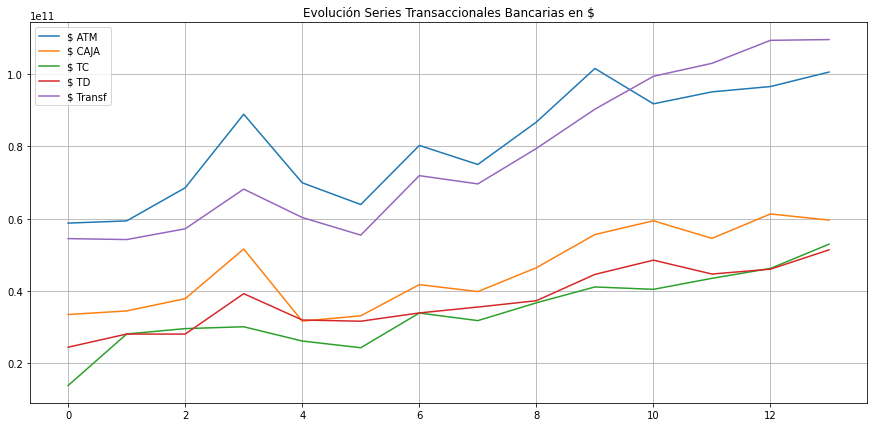

In [97]:
plt.figure(figsize=(15, 7))
plt.plot(trx_agrupmes.S_ATM, label='$ ATM')
plt.plot(trx_agrupmes.S_CAJA, label='$ CAJA')
plt.plot(trx_agrupmes.S_TC, label='$ TC')
plt.plot(trx_agrupmes.S_TD, label='$ TD')
plt.plot(trx_agrupmes.S_Transf, label='$ Transf')
plt.title('Evolución Series Transaccionales Bancarias en $')
plt.grid(True)
plt.legend()
plt.show()

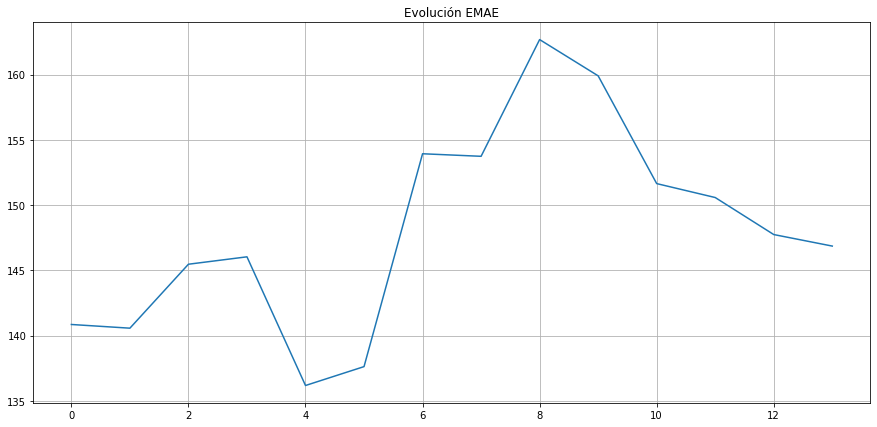

In [45]:
plt.figure(figsize=(15, 7))
plt.plot(emae.Indice)
plt.title('Evolución EMAE')
plt.grid(True)
plt.show()

<Figure size 1080x1440 with 0 Axes>

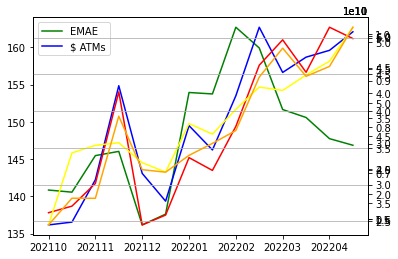

In [46]:
plt.figure(figsize=(15, 20))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 =ax1.twinx()
ax4 =ax1.twinx()
ax5 =ax1.twinx()
ax1.plot(trx_emae.Indice, label='EMAE', color='green')
ax2.plot(trx_emae.S_ATM, label='$ ATMs', color='blue')
ax3.plot(trx_emae.S_CAJA, label='$ CAJA', color='red')
ax4.plot(trx_emae.S_TC, label='$ TC', color='yellow')
ax5.plot(trx_emae.S_TD, label='$ TD', color='orange')
plt.grid(True)
lines = ax1.get_lines() + ax2.get_lines()
ax1.set_xticklabels(trx_emae.Periodo)
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')
plt.show()

<Figure size 1080x1440 with 0 Axes>

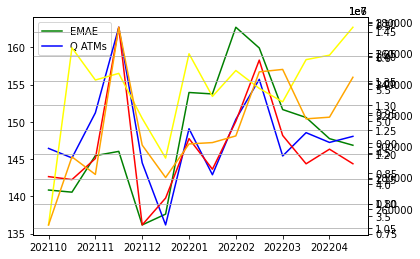

In [57]:
plt.figure(figsize=(15, 20))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 =ax1.twinx()
ax4 =ax1.twinx()
ax5 =ax1.twinx()
ax1.plot(trx_emae.Indice, label='EMAE', color='green')
ax2.plot(trx_emae.Q_ATM, label='Q ATMs', color='blue')
ax3.plot(trx_emae.Q_CAJA, label='Q CAJA', color='red')
ax4.plot(trx_emae.Q_TC, label='Q TC', color='yellow')
ax5.plot(trx_emae.Q_TD, label='Q TD', color='orange')
plt.grid(True)
lines = ax1.get_lines() + ax2.get_lines()
ax1.set_xticklabels(trx_emae.Periodo)
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')
plt.show()

##  2. Testeo y Modelado

### Verificación de estacionariedad de la serie EMAE

La teoria propone que un proceso estacionario tiene que tener todas sus raices >1.
Lo siguiente de la documentacion de DF me dice que el pvalue es el segundo resultado. Lo llamo con [1]


From:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

Returns:  
pvalue MacKinnon”s approximate p-value based on MacKinnon (1994, 2010).

In [47]:
# Como devuelve varios estadisticos, con 1 nos referimos al segundo, esto es, el p-value. Está debajo del umbral así que rechazamos Hipótesis Nula.
sm.tsa.stattools.adfuller(trx_emae.Indice)[1]


8.413394649025133e-14

### Verificación de autocorrelación de la serie EMAE

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


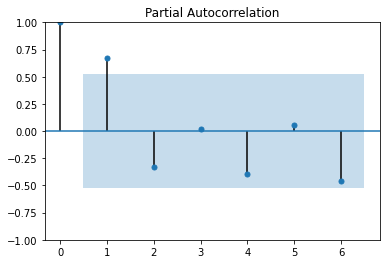

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(trx_emae.Indice, lags=6, alpha=0.05)
plt.show()

In [49]:
# AR(1)
mod = AutoReg(trx_emae.Indice, 1, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Indice   No. Observations:                   14
Model:                     AutoReg(1)   Log Likelihood                 -41.318
Method:               Conditional MLE   S.D. of innovations              5.809
Date:                Sat, 18 Feb 2023   AIC                             88.635
Time:                        15:17:12   BIC                             90.330
Sample:                             1   HQIC                            88.287
                                   14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.1885     30.314      1.854      0.064      -3.225     115.602
Indice.L1      0.6240      0.204      3.056      0.002       0.224       1.024
                                    Roots           

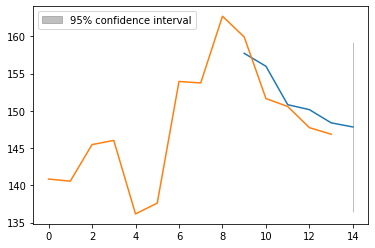

In [50]:
res.plot_predict(9,14)
plt.plot(emae.Indice)

In [51]:
sm.tsa.stattools.adfuller(res.resid)[1]
# se rechaza el unit root (i.e. sigue siendo estacionaria)

2.3443852109564136e-11

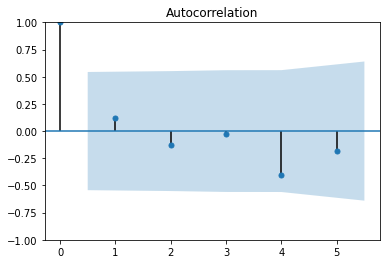

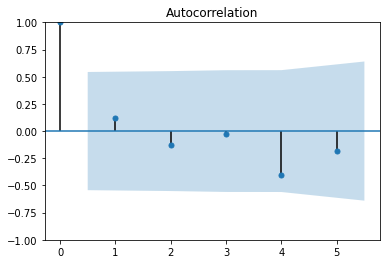

In [52]:
smt.graphics.plot_acf(res.resid, lags=5)
# No hay autocorrelación en los residuos

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


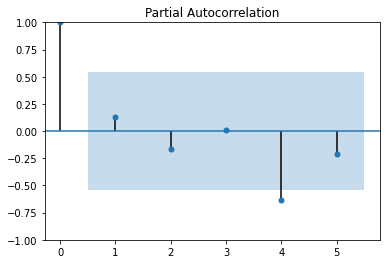

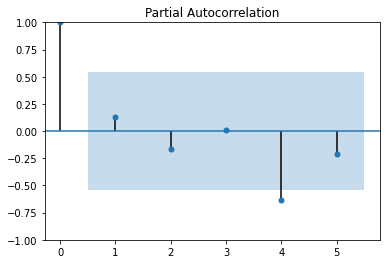

In [53]:
smt.graphics.plot_pacf(res.resid, lags=5, alpha=0.05)
# Tampoco autocorrelación parcial

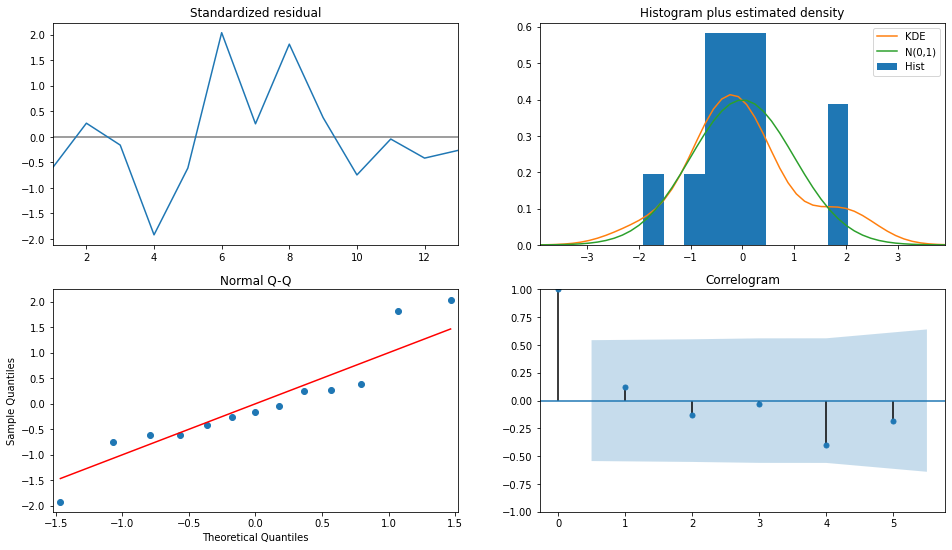

In [54]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=5)

In [76]:
# AR(1) con variables exógenas - Probamos 3 modelos

varlag1 = trx_emae.Q_CAJA.iloc[0:]
varlag2 = trx_emae.Q_ATM.iloc[0:]
mod2a = AutoReg(trx_emae.Indice[0:], 1, exog=np.column_stack([varlag1]), old_names=False)
mod2b = AutoReg(trx_emae.Indice[0:], 1, exog=np.column_stack([varlag2]), old_names=False)
mod2c = AutoReg(trx_emae.Indice[0:], 1, exog=np.column_stack([varlag1, varlag2]), old_names=False)
res2a = mod2a.fit()
print(res2a.summary())
res2b = mod2b.fit()
print(res2b.summary())
res2c = mod2c.fit()
print(res2c.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Indice   No. Observations:                   14
Model:                   AutoReg-X(1)   Log Likelihood                 -39.933
Method:               Conditional MLE   S.D. of innovations              5.222
Date:                Sat, 18 Feb 2023   AIC                             87.866
Time:                        15:40:07   BIC                             90.126
Sample:                             1   HQIC                            87.401
                                   14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.1494     27.401      1.867      0.062      -2.556     104.855
Indice.L1      0.4865      0.200      2.438      0.015       0.095       0.878
x1          8.453e-05   4.81e-05      1.757      0.0

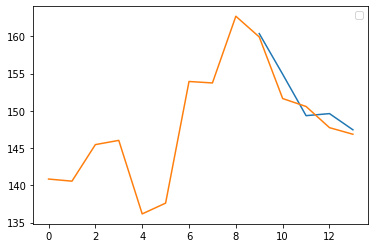

In [77]:
#El modelo 2a cumple con que la variable exógena es significativa al 10% de p-value y el BIC es levemente inferior al modelo base AR(1)
res2a.plot_predict(9,13, exog=varlag)
plt.plot(emae.Indice)

In [80]:
sm.tsa.stattools.adfuller(res2a.resid)[1]
# se rechaza el unit root (i.e. sigue siendo estacionaria)

9.804672821819367e-08

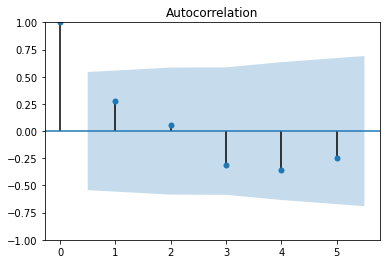

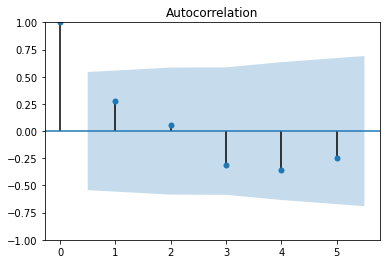

In [81]:
smt.graphics.plot_acf(res2a.resid, lags=5)
# No hay autocorrelación en los residuos

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


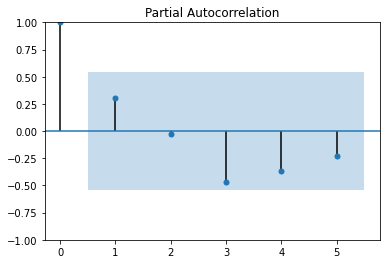

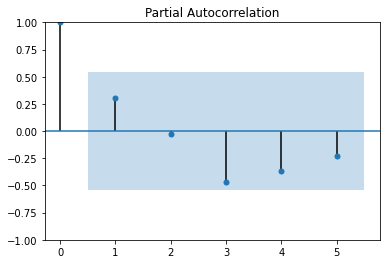

In [82]:
smt.graphics.plot_pacf(res2a.resid, lags=5, alpha=0.05)
# Tampoco autocorrelación parcial

In [79]:
# Para futura investigación -  AR(1) con Ciclo y Tendencia (A modelar con una serie más extensa)
# mod3 = ar_select_order(trx_emae.Indice,maxlag=2, trend='ct',seasonal=True, period=12)
#mod3.ar_lags
#res3 = mod3.model.fit()
#print(mod3.summary())